# ViNumQA Inference Notebook Overview

This notebook performs inference and lightweight evaluation on the ViNumQA dataset using a selection of small language models. It is designed to run on Google Colab and supports GPU acceleration, with A100 80GB recommended for highest throughput. The pipeline integrates `Transformers`, `Unsloth`, and `VLLM` to efficiently load and execute models.

The workflow includes mounting Google Drive to access the dataset, selecting and loading a model for testing, constructing prompts, analyzing dataset characteristics, executing batch inference, and saving results for post-processing.


## 1. Connect Google Drive, Load Data and Setting Library
This step mounts Google Drive into the notebook environment, locates the project directory, and loads `test.json`. The input is parsed into a usable structure ready for batching and inference.


### 

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import json

file_path = "/workspaces/Numerical-Reasoning-QA-for-Vietnamese-Finance/data/test.json"
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)


In [6]:
data[0]

{'pre_text': ['thuyết minh báo cáo tài chính hợp nhất ( tiếp theo ) 1 cơ sở trình bày và các chính sách kế toán ( tiếp theo ) sop 03-1 có hiệu lực đối với các báo cáo tài chính cho các năm tài chính bắt đầu sau ngày 15 tháng 12 năm 2003. tại ngày áp dụng lần đầu, ngày 1 tháng 1 năm 2004, ảnh hưởng lũy kế của việc áp dụng sop 03-1 đối với thu nhập ròng và thu nhập toàn diện khác bao gồm các tác động riêng lẻ sau đây được trình bày sau khi trừ đi lợi ích thuế thu nhập là 12 đô la: vào tháng 5 năm 2003, hội đồng chuẩn mực kế toán tài chính (“fasb”) đã ban hành chuẩn mực kế toán tài chính (“sfas”) số 150, “kế toán cho một số công cụ tài chính có đặc điểm của cả nợ phải trả và vốn chủ sở hữu”.',
  'sfas số 150 thiết lập các tiêu chuẩn để phân loại và đo lường một số công cụ tài chính thể hiện nghĩa vụ của bên phát hành và có đặc điểm của cả nợ phải trả và vốn chủ sở hữu là nợ phải trả.',
  'nói chung, sfas số 150 yêu cầu phân loại nợ phải trả cho hai loại công cụ tài chính lớn: (a) các công

In [7]:
len(data)


497

In [5]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9]{1,}\.[0-9]{1,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.33.post1" if v=="2.9" else "0.0.32.post2" if v=="2.8" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2
!pip install vllm

## 2. Load Model and Choose a Variant
Users may select among multiple models (e.g., Qwen, Mistral, Llama, Phi-4). The notebook leverages Unsloth for memory-efficient model loading and uses VLLM as the inference engine to enable fast batched decoding. Compared with sequential inference using plain Transformers, this setup dramatically reduces runtime on large datasets.


In [4]:
import sys, os
# LƯU IO CŨ
_old_stdout = sys.stdout
_old_stderr = sys.stderr
_old_stdin  = sys.stdin
# tắt IO notebook
sys.stdin = open(os.devnull, 'r')
sys.stdout = open(os.devnull, 'w')
sys.stderr = open(os.devnull, 'w')

In [ ]:
# Choose model
model = [
    "unsloth/mistral-7b-instruct-v0.3",
    "unsloth/Phi-4",
    "unsloth/Llama-3.1-8B",
    "unsloth/gemma-3-4b-it-unsloth-bnb-4bit"
    "unsloth/Qwen3-8B"
]

model_name = "unsloth/Phi-4"

# Choose max_seq long enough for model user reason before give last answer
max_seq_length = 15000

In [ ]:
import unsloth
from unsloth import FastLanguageModel
import torch
dtype = None
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    dtype = dtype, # None for auto detection
    max_seq_length = max_seq_length, # Choose any for long context!
    load_in_4bit = True,  # 4 bit quantization to reduce memory
    fast_inference =True
)

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:

# ===== KHÔI PHỤC IO =====
sys.stdin  = _old_stdin
sys.stdout = _old_stdout
sys.stderr = _old_stderr

## 3. Build Prompt and Chat Templates
This section defines the system prompt, task instructions, and model-specific chat formatting. Variables and placeholders are constructed so that each sample is injected into a standardized prompt form suitable for program-generation reasoning.


In [ ]:
# FastLanguageModel.for_inference(model)
# ==================== 1. THƯ VIỆN + MODEL + TOKENIZER ====================
import re
import csv
# ==================== 2. HÀM CHUYỂN BẢNG ====================
def table_to_str(table):
    if not table or not isinstance(table, list):
        return "Không có bảng."
    lines = []
    for row in table[:30]:
        if isinstance(row, list):
            cleaned = [str(cell).replace('$','').replace(',','').strip() for cell in row]
            lines.append(" | ".join(cleaned))
    if not lines:
        return "Bảng rỗng."
    sep = "--- | " * (len(lines[0].split("|")) - 1) + "---"
    return "\n".join([lines[0], sep] + lines[1:])
# ==================== 3. SYSTEM PROMPT + CHAT TEMPLATE ====================
SYSTEM_INSTRUCTION = """Bạn là chuyên gia phân tích báo cáo tài chính Việt Nam, nhiệm vụ của bạn là tìm ra số liệu trong câu hỏi và thực hiện các phép toán cần thiết, dưới đây là hướng dẫn.
=== DANH SÁCH PHÉP TOÁN===
- add(a, b): Cộng 2 số hoặc cộng tiếp kết quả trước (#0, #1).
  → Dùng khi hỏi “tổng”, “cộng”, “cộng dồn”, “tổng X năm”.
- subtract(a, b): Trừ a − b.
  → Dùng cho chênh lệch tuyệt đối, tăng/giảm tuyệt đối.
- multiply(a, b): Nhân.
  → Thường dùng khi đã có hệ số sẵn (1.15, 1.03, 0.95…) hoặc tính giá trị năm nay từ năm cũ + % tăng.
- divide(a, b): Chia a / b.
  → Gần như bắt buộc khi hỏi % tăng trưởng, tỷ lệ, tỷ trọng.
- add(1, x) + multiply/divide: Pattern vàng khi đảo chiều tăng trưởng
  Ví dụ biết năm nay tăng 20% → muốn tính năm trước: add(1, 0.20) → divide(năm_nay, #0)
- table_max(column, none): Giá trị lớn nhất của cột.
- table_min(column, none): Giá trị nhỏ nhất của cột.
- table_average(column, none): Giá trị trung bình của cột.
- table_sum(column, none): Tổng cả cột (chỉ dùng khi hỏi tổng cả cột/hàng, không dùng cho 2-3 ô).
→ Lưu ý quan trọng: table_ functions chỉ nhận đúng 1 cột, không thêm hàng.
→ #0 = kết quả phép đầu tiên, #1 = phép thứ hai, #2 = phép thứ ba… (rất hay dùng khi cộng nhiều lần hoặc tính tăng trưởng phức tạp).
→ Các giá trị tròn trong phép toán ví dụ số nguyên như 100.00 thì viết dưới dạng 100, ví dụ subtract(124.6, 100) thay vì add(124.5, 100.00)
=== HƯỚNG DẪN CHỌN PHÉP TOÁN THEO TỪ KHÓA ===
1. Tăng trưởng bao nhiêu % / Tỷ lệ tăng trưởng / Tăng …% so với / +…% yoy / Tăng … lần
   → Luôn dùng pattern chuẩn: subtract(mới, cũ), divide(#0, cũ)
   Ví dụ: tăng 15% → subtract(mới, cũ) → chia cho giá trị cũ
2. Giảm bao nhiêu % / Giảm …% yoy / -…% yoy
   → Vẫn dùng đúng pattern trên (kết quả sẽ âm → đúng bản chất giảm)
3. Tăng trưởng tuyệt đối / Tăng thêm bao nhiêu / Chênh lệch / Hơn … đơn vị
   → Chỉ dùng: subtract(mới, cũ) (không chia)
4. Tính giá trị năm trước khi biết năm nay + % tăng
   → Ví dụ “năm nay tăng 10% so với năm trước”
   → add(1, 0.10) → divide(năm_nay, #0)
5. Tính giá trị năm nay khi biết năm trước + % tăng
   → add(1, tỷ_lệ_tăng) → multiply(năm_trước, #0)
   Hoặc viết tắt: multiply(năm_trước, 1.xx) (xx = % tăng)
6. Tổng / Tổng cộng / Cộng … năm / Trong vòng X năm
   → Dùng add liên tiếp: add(a,b), add(#0,c), add(#0,d)...
   → Nếu chỉ 2 số thì add(a,b) là đủ
   → Nếu ≥3 số thì cứ add liên tục, dùng #0, #1 để tham chiếu
7. Cao nhất/ Lớn nhất / Nhỏ nhất trong giai đoạn / trong bảng
   → table_max(tên cột, none)
8. Thấp nhất/ Nhỏ nhất trong giai đoạn / trong bảng
   → table_min(tên cột, none)
8. Trung bình / Bình quân
   → table_average(tên cột, none)
9. Tỷ lệ / Chiếm bao nhiêu % / Tỷ trọng / Phần trăm của … so với …
   → divide(giá_trị, tổng_cùng_loại)
10. Tính lại giá trị khi đã có hệ số (ví dụ dự phóng = năm cũ × 1.03)
    → multiply(cũ, 1.xx) hoặc multiply(cũ, hệ_số), không dùng multiply(#0, 100) hay multiply(#1, 100) hay bất kỳ multiply nào để nhân với 100 để tính phần trăm
11. Các cụm từ KHÔNG dùng table_sum (vì chỉ tính tổng 1 cột/hàng):
    - “tổng lợi nhuận 3 năm” → add liên tiếp, không dùng table_sum, ví dụ tổng 3 năm là 345, 435,356 tỷ đồng thì tính add(345, 435), add(#0, 356)
    - “tổng của cột X” → mới dùng table_sum(tên cột, none)
12. Các từ khóa thường dùng table_ (không cần add/subtract thủ công):
    - cao nhất, lớn nhất, thấp nhất, nhỏ nhất, trung bình, bình quân, tổng của cột, sử dụng tên của cột chứ không cho mảng vào
13. Khi cần tìm số lớn nhất trong cột nhưng số đó được dùng để tính toán cho kết quả khác ví dụ 1 phép cộng khác thì không cần dùng table_max để lấy giá trị lớn nhất mà trực tiếp lấy ra giá trị lớn nhất cho vào add()
14. Không được tự ý suy luận và chuyển đổi giá trị mà không dùng phép toán, mọi quy đổi cần dùng phép tính để tính ra, ví dụ khi tính các giá trị khác đơn vị đo lường cần phải dùng multiply hoặc divide để quy rổi ra cùng đơn vị ra trước, không được tự ý suy luận 1.0 tỷ bằng 1000 triệu, ví dụ cần trừ 1 tỷ cho 900 triệu thì nếu dùng đơn vị triệu thì cần dùng multiply(1, 1000) để quy đối sang triệu trước khi trừ, sau đó mới dùng subtract(#0, 900), program sẽ là: multiply(1, 1000), subtract(#0,900), không được trực tiếp dùng subtract(1000, 900), ví dụ tỉ lệ của 800 triệu và 6.0 tỷ cần dùng multiply(6, 1000) trước.
- Trả lời đúng 2 dòng:
  program: <Các chương trình phép toán, nếu có nhiều phép toán, cần sử dụng #0, #1, #2 hợp lý để chỉ có 1 đầu ra cuối cùng và không thừa phép tính, lưu ý tuyệt đối không sử dụng multiply(#0, 100) vì khi tính tỉ lệ thì trực tiếp ghỉ ra số thập phân ví dụ tỉ lệ phần trăm của...là 15% thì là 0.15, ngoài ra các số khác như tiền tỷ đều viết liền, chỉ dùng dấu chấm đển ngăn cách số thập phân>
  answer: <Kết quả là số thập phân và quy đổi ra số thập phân, ví dụ 15% thì là 0.15, làm tròn 5 chữ số nếu quá dài, ví dụ 1.399994 thì làm tròn xuống 1.39999, 1.3200 thì là 1.32, là kết quả cuối của program>
- Lưu ý: các phép toán cần phải viết lần lượt, không lồng vào nhau ví dụ viết add(1, 0.15), divide(5310, #0) chứ không viết divide(5310, add(1, 0.15))
- Lưu ý 2: đối với các số liệu thì trong phần nội dung liên quan đến câu hỏi xuất hiện như thế nào thì cần ghi vào phép tính như thế, ví dụ trong phần thông tin liên quan đưa ra con số 5.0 tỷ thì không được tự ý cho rằng đó là 5000 triệu, nếu cần đổi sang triệu cần dùng multiply(5, 1000) trước, hoặc nếu cần cộng 2 số 35.5% và 14.5% thì ghi add(35.5%, 14.5%).
=== VÍ DỤ ===
Ví dụ 1:
Câu hỏi: Doanh thu lớn nhất từ 2015 đến 2019F là bao nhiêu?
Pre-text: Năm 2019F doanh thu giảm...
Bảng:
FY (Dec.) | 2015 | 2016 | 2017 | 2018E | 2019F
--- | --- | --- | --- | --- | ---
Doanh thu (tỷ) | 125 | 147 | 146 | 532 | 189
Output:
program: table_max(Doanh thu (tỷ), none)
answer: 532.0
Ví dụ 2:
Câu hỏi: Giá trị hàng tồn kho đầu năm là bao nhiêu?
Pre-text: Hàng tồn kho tăng 15% so với đầu năm lên 5310 tỷ...
Bảng: None
Output:
program: add(1, 0.15), divide(5310, #0)
answer: 4617.3913
==== CÂU HỎI ====
"""
SYSTEM_EVALUATOR = """Bạn là chuyên gia đánh giá kết quả phân tích báo cáo tài chính Việt Nam, nhiệm vụ của bạn là kiểm tra xem program và answer đã sinh ra có chính xác, thỏa mãn các điều kiện chưa, nếu sai thì sửa, dựa trên câu hỏi và dữ liệu, đưa ra câu trả lời đúng phù hợp với quy tắc, dưới đây là hướng dẫn.
=== DANH SÁCH PHÉP TOÁN===
- add(a, b): Cộng 2 số hoặc cộng tiếp kết quả trước (#0, #1).
  → Dùng khi hỏi “tổng”, “cộng”, “cộng dồn”, “tổng X năm”.
- subtract(a, b): Trừ a − b.
  → Dùng cho chênh lệch tuyệt đối, tăng/giảm tuyệt đối.
- multiply(a, b): Nhân.
  → Thường dùng khi đã có hệ số sẵn (1.15, 1.03, 0.95…) hoặc tính giá trị năm nay từ năm cũ + % tăng.
- divide(a, b): Chia a / b.
  → Gần như bắt buộc khi hỏi % tăng trưởng, tỷ lệ, tỷ trọng.
- add(1, x) + multiply/divide: Pattern vàng khi đảo chiều tăng trưởng
  Ví dụ biết năm nay tăng 20% → muốn tính năm trước: add(1, 0.20) → divide(năm_nay, #0)
- table_max(column, none): Giá trị lớn nhất của cột.
- table_min(column, none): Giá trị nhỏ nhất của cột.
- table_average(column, none): Giá trị trung bình của cột.
- table_sum(column, none): Tổng cả cột (chỉ dùng khi hỏi tổng cả cột/hàng, không dùng cho 2-3 ô).
→ Lưu ý quan trọng: table_ functions chỉ nhận đúng 1 cột, không thêm hàng.
→ #0 = kết quả phép đầu tiên, #1 = phép thứ hai, #2 = phép thứ ba… (rất hay dùng khi cộng nhiều lần hoặc tính tăng trưởng phức tạp).
→ Các giá trị tròn trong phép toán ví dụ số nguyên như 100.00 thì viết dưới dạng 100, ví dụ subtract(124.6, 100) thay vì add(124.5, 100.00)
=== HƯỚNG DẪN CHỌN PHÉP TOÁN THEO TỪ KHÓA ===
1. Tăng trưởng bao nhiêu % / Tỷ lệ tăng trưởng / Tăng …% so với / +…% yoy / Tăng … lần
   → Luôn dùng pattern chuẩn: subtract(mới, cũ), divide(#0, cũ)
   Ví dụ: tăng 15% → subtract(mới, cũ) → chia cho giá trị cũ
2. Giảm bao nhiêu % / Giảm …% yoy / -…% yoy
   → Vẫn dùng đúng pattern trên (kết quả sẽ âm → đúng bản chất giảm)
3. Tăng trưởng tuyệt đối / Tăng thêm bao nhiêu / Chênh lệch / Hơn … đơn vị
   → Chỉ dùng: subtract(mới, cũ) (không chia)
4. Tính giá trị năm trước khi biết năm nay + % tăng
   → Ví dụ “năm nay tăng 10% so với năm trước”
   → add(1, 0.10) → divide(năm_nay, #0)
5. Tính giá trị năm nay khi biết năm trước + % tăng
   → add(1, tỷ_lệ_tăng) → multiply(năm_trước, #0)
   Hoặc viết tắt: multiply(năm_trước, 1.xx) (xx = % tăng)
6. Tổng / Tổng cộng / Cộng … năm / Trong vòng X năm
   → Dùng add liên tiếp: add(a,b), add(#0,c), add(#0,d)...
   → Nếu chỉ 2 số thì add(a,b) là đủ
   → Nếu ≥3 số thì cứ add liên tục, dùng #0, #1 để tham chiếu
7. Cao nhất/ Lớn nhất / Nhỏ nhất trong giai đoạn / trong bảng
   → table_max(tên cột, none)
8. Thấp nhất/ Nhỏ nhất trong giai đoạn / trong bảng
   → table_min(tên cột, none)
8. Trung bình / Bình quân
   → table_average(tên cột, none)
9. Tỷ lệ / Chiếm bao nhiêu % / Tỷ trọng / Phần trăm của … so với …
   → divide(giá_trị, tổng_cùng_loại)
10. Tính lại giá trị khi đã có hệ số (ví dụ dự phóng = năm cũ × 1.03)
    → multiply(cũ, 1.xx) hoặc multiply(cũ, hệ_số), không dùng multiply(#0, 100) hay multiply(#1, 100) hay bất kỳ multiply nào để nhân với 100 để tính phần trăm
11. Các cụm từ KHÔNG dùng table_sum (vì chỉ tính tổng 1 cột/hàng):
    - “tổng lợi nhuận 3 năm” → add liên tiếp, không dùng table_sum, ví dụ tổng 3 năm là 345, 435,356 tỷ đồng thì tính add(345, 435), add(#0, 356)
    - “tổng của cột X” → mới dùng table_sum(tên cột, none)
12. Các từ khóa thường dùng table_ (không cần add/subtract thủ công):
    - cao nhất, lớn nhất, thấp nhất, nhỏ nhất, trung bình, bình quân, tổng của cột, sử dụng tên của cột chứ không cho mảng vào
13. Khi cần tìm số lớn nhất hoặc nhỏ nhất trong cột nhưng số đó được dùng để tính toán cho kết quả khác ví dụ 1 phép cộng khác thì không cần dùng table_max/table_min để lấy giá trị lớn nhất mà trực tiếp lấy ra giá trị lớn nhất/nhỏ nhất cho vào add()
14. Khi tính các giá trị khác đơn vị đo lường cần phải dùng multiply hoặc divide để quy rổi ra cùng đơn vị ra trước, ví dụ cần trừ 1 tỷ cho 900 triệu thì nếu dùng đơn vị triệu thì cần dùng multiply(1, 1000) để quy đối sang triệu trước khi trừ: subtract(#0, 900), không được trực tiếp dùng subtract(1000, 900), ví dụ tỉ lệ của 800 triệu và 6.0 tỷ cần dùng multiply(6, 1000) trước
=== QUY TẮC SỬ DỤNG ===
- Trước tiên phân tích xem phần program và answer đã sinh ra trước đó có thực sự đúng với câu hỏi và trích xuất đúng thông tin chưa.
- Lưu ý đặc biệt: nếu là số nguyên thì cần viết thành số nguyên chứ không thêm .00, ví dụ add(134.5, 100) chứ không phải add(134.5, 100.00), và không sử dụng multiply(#0, 100) hay multiply(#n, 100) nếu có nhiều phép toán để tính tỉ lệ gì đó, vì answer chỉ cần là số thập phân, chỉ có 1 đầu ra answer, ví dụ nếu có nhiều phép tính thì lấy kết quả là đầu ra của phép cuối cùng, phép đó cần dùng #0, #1,.. nếu có nhiều phép tính để liên kết với các kết quả của các phép tính trước đó, không tính thừa, ví dụ add(1, 0.15), add(#0, 0.25), divide(#1, 2) là ra 1 answer.
- Sau khi phân tích hãy viết lại đúng kết quả theo cấu trúc program:.... answer:... trong ```plaintext ... ```
=== VÍ DỤ ===
== Ví dụ 1 ==
Câu hỏi: Tỷ lệ lợi nhuận tích lũy tổng cộng theo phần trăm của Goldman Sachs Group Inc. từ ngày 12/26/08 đến ngày 12/31/13
Pre-text: Hàng tồn kho tăng 15% so với đầu năm lên 5310 tỷ...
Bảng:[
            [
                "",
                "12/26/08",
                "12/31/09",
                "12/31/10",
                "12/31/11",
                "12/31/12",
                "12/31/13"
            ],
            [
                "tập đoàn goldman sachs inc .",
                "$ 100.00",
                "$ 224.98",
                "$ 226.19",
                "$ 123.05",
                "$ 176.42",
                "$ 248.36"
            ]
      ]
Kết quả đã sinh:
Để tính tỷ lệ lợi nhuận tích lũy tổng cộng theo phần trăm của Goldman Sachs Group Inc...

```plaintext
program: subtract(248.36, 100.00), divide(#0, 100.00)
```
Kết quả sẽ là:
```plaintext
answer: 1.4836
```

Bạn cần phần tích và trả lời như sau:
1. Thông tin liên quan đến câu hỏi: Tỷ lệ lợi nhuận tích lũy tổng cộng theo phần trăm của Goldman Sachs Group Inc. từ 12/26/08 đến 12/31/13
   → Giá trị ban đầu (12/26/08): 100.00
   → Giá trị cuối cùng (12/31/13): 248.36

2. Công thức tính tỷ lệ lợi nhuận tích lũy (tổng cộng theo phần trăm):
   \[
   \text{Tỷ lệ} = \frac{\text{Giá trị cuối} - \text{Giá trị đầu}}{\text{Giá trị đầu}} = \frac{248.36 - 100.00}{100.00}
   \]

3. Kiểm tra kết quả cũ:
   - Kết quả cũ: `subtract(248.36, 100.00), divide(#0, 100.00)` → đúng về mặt toán học nhưng vi phạm 2 điều kiện mới:
     • Dùng 100.00 thay vì 100 (không cần .00 khi là số nguyên)
     • Tách thành 2 khối code riêng biệt thay vì 1 khối plaintext duy nhất

4. Sửa lại cho đúng mọi điều kiện mới:
   - Không dùng multiply(#n, 100) nào cả: Đã thỏa mãn
   - Dùng số nguyên 100 thay vì 100.00: Đã thỏa mãn
   - Chỉ 1 khối ```plaintext duy nhất chứa cả program và answer: Đã thỏa mãn
   - Answer là số thập phân thuần, không thêm %: Đã thỏa mãn

Vậy kết quả đúng và thỏa mãn toàn bộ điều kiện là:
```plaintext
program: subtract(248.36, 100), divide(#0, 100)
answer: 1.4836
```

== Ví dụ 2 ==
Câu hỏi: Tỷ trọng của khoản mục “Chi phí quản lý doanh nghiệp” trong tổng doanh thu thuần năm 2021 của công ty là bao nhiêu?

Pre-text: Năm 2021, doanh thu thuần đạt 18,6 tỷ đồng. Chi phí quản lý doanh nghiệp là 892 triệu đồng.

Bảng: Không có bảng, thông tin lấy trực tiếp từ pre-text.

Kết quả đã sinh (cũ):
Doanh thu thuần: 18,6 tỷ đồng
Chi phí quản lý doanh nghiệp: 892 triệu đồng

Để tính tỷ trọng, cần đưa về cùng đơn vị. Ta chuyển 18,6 tỷ thành triệu đồng = 18.600 triệu đồng.
Sau đó tính 892 / 18.600 ≈ 0,0480 (tức 4,80%)

Kết quả cũ đưa ra:

```plaintext
program: divide(892, 18600)
answer: 0.0480
```

Bạn cần phân tích và trả lời như sau:
1. Thông tin liên quan đến câu hỏi:
   → Chi phí quản lý doanh nghiệp năm 2021: 892 triệu đồng
   → Doanh thu thuần năm 2021: 18,6 tỷ đồng

2. Công thức tính tỷ trọng:
   \[
   \text{Tỷ trọng} = \frac{\text{Chi phí quản lý doanh nghiệp}}{\text{Doanh thu thuần}}
   \]

3. Kiểm tra kết quả cũ:
   - Response cũ tự tính tay 18,6 × 1000 = 18600 rồi dùng trực tiếp số 18600 → vi phạm điều kiện 4.
   - Khi hai số có đơn vị khác nhau (triệu đồng và tỷ đồng), bắt buộc phải thực hiện phép quy đổi bằng multiply hoặc divide ngay trong program, không được tự nhân tay bên ngoài.
   - Không dùng multiply(#n, 100) → thỏa mãn.
   - Answer 0.0480 là chính xác về toán học.
   - Các phép tính không lồng nhau, không cần sửa, tuy nhiên nếu lồng nhau ví dụ divide(892, add(18000, 600)) thì cần tách thành 2 phép tính, nhưng ở đây không cần vì chỉ có 1 phép tính.
   - Câu hỏi không nói về độ giảm nên bỏ qua, nhưng nếu nó về độ giảm thì cần dùng số bé hơn để trừ số lớn để tính độ giảm

4. Sửa lại cho đúng mọi điều kiện mới:
   - Phải thể hiện rõ bước quy đổi 18,6 tỷ → triệu đồng bằng multiply(18.6, 1000) trong program
   - Dùng đúng số gốc trong đề bài là 18.6 (không viết 18,6 hay 18600)
   - Không dùng multiply bằng 100 để ra phần trăm
   - Chỉ dùng một khối plaintext duy nhất

Vậy kết quả đúng và hoàn toàn thỏa mãn mọi điều kiện là:
```plaintext
program: multiply(18.6, 1000), divide(892, #0)
answer: 0.0480
```

==== CÂU HỎI ====
"""
def build_chat_prompt(sample):
    question = sample["qa"]["question"]
    pre_text = " ".join(sample.get("pre_text", [])).strip()
    post_text = " ".join(sample.get("post_text", [])).strip()
    table = table_to_str(sample.get("table", []))
    user_message = f"""Câu hỏi: {question}
Câu trả lời phải tuân theo định dạng:
```plaintext
program:.....
answer:....
```
Đây là nội dung liên quan đến câu hỏi:
Pre-text: {pre_text}
Post-text: {post_text}
Bảng:
{table}

Phân tích bằng tiếng việt, dừng trả lời sau khi đưa ra câu trả lời cuối cùng trong khối ```plaintext ... ```
Output:"""
    messages = [
        {"role": "system", "content": SYSTEM_INSTRUCTION},
        {"role": "user", "content": user_message}
    ]
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    return prompt
def build_evaluator_prompt(sample, initial_response):
    question = sample["qa"]["question"]
    pre_text = " ".join(sample.get("pre_text", [])).strip()
    post_text = " ".join(sample.get("post_text", [])).strip()
    table = table_to_str(sample.get("table", []))
    user_message = f"""Câu hỏi: {question}
Đây là nội dung liên quan đến câu hỏi:
Pre-text: {pre_text}
Post-text: {post_text}
Bảng:
{table}
Đây là phân tích và kết quả:
{initial_response}

====NHIỆM VỤ CỦA BẠN====
Hãy phân tích và kiểm tra xem phân tích và kết quả trước đã chính xác thỏa mãn các điều kiện chưa, nếu sai thì hãy sửa lại, thêm bớt cho đúng:
Các điều cần chú ý khi phân tích:
1. không dùng multiply(#n, 100) để tính phần trăm, tỉ lệ, tóm lại nếu có multiply(#n, 100) mà 100 có ý nghĩa 100% thì loại bỏ nó.
2. viết chưa đúng định dạng program:... answer:... sau khi phân tích hãy viết lại đúng kết quả theo cấu trúc program:.... answer:... trong ```plaintext ... ```.
3. Nếu là số nguyên thì cần viết thành số nguyên chứ không thêm .00, ví dụ add(134.5, 100) chứ không phải add(134.5, 100.00), chỉ có 1 đầu ra answer, ví dụ nếu có nhiều phép tính thì lấy kết quả là đầu ra của phép cuối cùng, phép đó cần dùng #0, #1,.. nếu có nhiều phép tính để liên kết với các kết quả của các phép tính trước đó, không tính thừa, ví dụ add(1, 0.15), add(#0, 0.25), divide(#1, 2) là ra 1 answer.
4. Khi tính các giá trị khác đơn vị đo lường cần phải dùng multiply hoặc divide trong program để quy đổi ra cùng đơn vị ra trước, ví dụ cần trừ 1 tỷ cho 900 triệu thì nếu dùng đơn vị triệu thì cần dùng multiply(1, 1000) để quy đối sang triệu trước khi trừ: subtract(#0, 900), không được trực tiếp dùng subtract(1000, 900), ví dụ tỉ lệ của 800 triệu và 6.0 tỷ cần dùng multiply(6, 1000) trước.
5. Kiểm tra kỹ xem phân tích đã lấy ra đúng thông tin chưa, nếu sai, phân tích lại.
6. program phải đúng định dạng được yêu cầu, nếu có nhiều phép toán, cần sử dụng #0, #1, #2 hợp lý để chỉ có 1 đầu ra cuối cùng và không thừa phép tính, các phép toán không được lồng vào nhau, ví dụ: không dùng divide(30, add(1, 0.3)) mà cần sửa lại thành add(1, 0.3), divide(30, #0).
7. Chú ý đến các câu hỏi hỏi về tỉ lệ giảm, giảm bao nhiêu, khi đó cần tính số âm để tìm ra tỉ lệ giảm, ví dụ giảm từ 553 xuống còn 500, tính tỉ lệ giảm cần dùng: subtract(500, 553), divide(#0, 553) không phải subtract(553, 500), divide(#0, 553).
6. Bắt buộc phải đưa ra ```plaintext.
program:...
answer:...
```
7. Dừng trả lời khi đưa ra xong kết quả trong ```plaintext... ```
"""
    messages = [
        {"role": "system", "content": SYSTEM_EVALUATOR},
        {"role": "user", "content": user_message}
    ]
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    return prompt



## 4. Dataset Analysis and Statistics
Basic inspection of the test set is performed, including token length estimation, question distribution, and other metrics that approximate computational cost. Visual summaries provide insight into difficulty and aid resource planning.


In [10]:
def count_prompt_tokens(prompt: str, tokenizer):
    return len(tokenizer(prompt, add_special_tokens=False).input_ids)
prompt_lengths = []

for sample in data:
    prompt = build_chat_prompt(sample)
    n_tokens = count_prompt_tokens(prompt, tokenizer)
    prompt_lengths.append(n_tokens)


In [11]:
import numpy as np

arr = np.array(prompt_lengths)

stats = {
    "min": int(arr.min()),
    "mean": float(arr.mean()),
    "p90": int(np.percentile(arr, 90)),
    "p95": int(np.percentile(arr, 95)),
    "p99": int(np.percentile(arr, 99)),
    "max": int(arr.max()),
}

stats


{'min': 2447,
 'mean': 3451.5613682092553,
 'p90': 3950,
 'p95': 4087,
 'p99': 4429,
 'max': 5379}

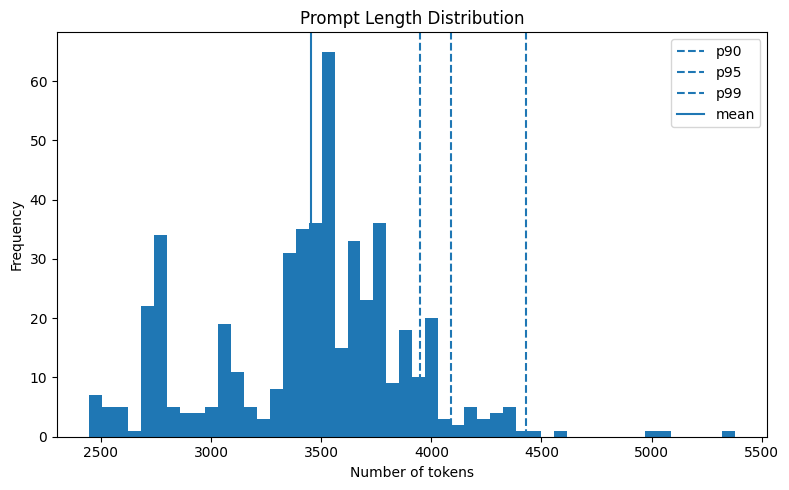

In [12]:
import matplotlib.pyplot as plt
import numpy as np

arr = np.array(prompt_lengths)

plt.figure(figsize=(8, 5))
plt.hist(arr, bins=50)
plt.axvline(np.percentile(arr, 90), linestyle='--', label='p90')
plt.axvline(np.percentile(arr, 95), linestyle='--', label='p95')
plt.axvline(np.percentile(arr, 99), linestyle='--', label='p99')
plt.axvline(arr.mean(), linestyle='-', label='mean')

plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.title("Prompt Length Distribution")
plt.legend()
plt.tight_layout()
plt.show()


## 5. Batched Inference with VLLM/Unsloth
Inference is executed over the full test split using batched decoding to maximize GPU utilization. Each input sample is transformed into a formatted prompt and submitted to the model. Outputs are collected and saved in JSON or another structured format for later testing and scoring.


In [ ]:

import re
import csv
import random
import os
from tqdm import tqdm
from google.colab import drive
from vllm import SamplingParams
import gc
# ==================== MOUNT + THƯ MỤC ====================
drive.mount('/content/Drive', force_remount=True)
save_dir = "/content/Drive/MyDrive/viNumQA_program_analysis"
os.makedirs(save_dir, exist_ok=True)
# ==================== 1. TRÍCH XUẤT PROGRAM SIÊU CHẶT ====================
def extract_program(response):
    response = response.strip()
    # Tìm khối program: chính xác từ "program:" đến trước "answer:" hoặc hết
    match = re.search(r'program:\s*(.+?)(?=\s*answer:|\Z)', response, re.S | re.I)
    if match:
        prog = match.group(1).strip()
        # Loại bỏ các ký tự thừa như }, ], \n, ``` còn sót lại
        prog = re.sub(r'[}\]\n`]+$', '', prog).strip()
        return prog
    return None
# ==================== 2. CHUẨN HÓA PROGRAM MỚI NHẤT ====================
def normalize_program(prog):
    if not prog:
        return ""
    prog = re.sub(r'\s+', '', prog) # Xóa hết space
    # 1. Cộng và nhân: giao hoán → sắp xếp lại tham số (chỉ sort cho add và multiply)
    prog = re.sub(r'add\(([^,]+),([^)]+)\)', lambda m: 'add(' + ','.join(sorted([m.group(1), m.group(2)])) + ')', prog)
    prog = re.sub(r'multiply\(([^,]+),([^)]+)\)', lambda m: 'multiply(' + ','.join(sorted([m.group(1), m.group(2)])) + ')', prog)
    # 2. Trừ và chia: KHÔNG sort, KHÔNG thay đổi thứ tự vì sai logic
    prog = re.sub(r'subtract\(([^,]+),([^)]+)\)', lambda m: f"subtract({m.group(1)},{m.group(2)})", prog)
    prog = re.sub(r'divide\(([^,]+),([^)]+)\)', lambda m: f"divide({m.group(1)},{m.group(2)})", prog)
    # Đánh số lại #0, #1, #2… theo thứ tự xuất hiện
    used = {}
    counter = 0
    def replace_ref(m):
        nonlocal counter
        ref = m.group(0)
        if ref not in used:
            used[ref] = f"#{counter}"
            counter += 1
        return used[ref]
    prog = re.sub(r'#\d+', replace_ref, prog)
    # Bỏ phần sort subtract và divide để tránh sai logic (không swap vị trí)
    return prog
def extract_from_plaintext(response):
    matches = re.findall(r'```plaintext\s*(.+?)\s*```', response, re.S | re.I)
    if matches:
        content = matches[-1].strip()  # Lấy khối plaintext cuối cùng
        prog_match = re.search(r'program:\s*(.+?)(?=\s*(answer|output):|\Z)', content, re.S | re.I)
        prog = prog_match.group(1).strip() if prog_match else None

        ans_match = re.search(r'(answer|output):\s*(.+)', content, re.S | re.I)
        ans = ans_match.group(2).strip() if ans_match else None

        return prog, ans
    return None, None
def extract_answer(response):
    response = response.strip()
    match = re.search(r'(answer|output):\s*(.+)', response, re.S | re.I)
    if match:
        ans = match.group(2).strip()
        return ans
    return None
# ==================== INFERENCE TOÀN BỘ TẬP TEST ====================
random.seed(27)
candidate_indices = list(range(0, len(data)))
selected_indices = random.sample(candidate_indices, len(data))
selected_indices.sort()

# Định nghĩa SamplingParams
sampling_params = SamplingParams(
    temperature=0.1,
    max_tokens=3000,
)

results = []  # Để lưu chi tiết từng sample
metrics = {}  # Để lưu metrics tổng

batch_size = 500

# Bước 1: Thu thập tất cả prompt cho step 1
all_prompts_step1 = []
for idx in selected_indices:
    sample = data[idx]
    prompt = build_chat_prompt(sample)
    all_prompts_step1.append(prompt)

# Inference batch cho step 1 với fast_generate và SamplingParams
responses_step1 = []
for i in tqdm(range(0, len(all_prompts_step1), batch_size), desc="Step 1 Batches"):
    batch = all_prompts_step1[i:i+batch_size]
    vllm_outputs = model.fast_generate(batch, sampling_params=sampling_params)
    batch_responses = [output.outputs[0].text for output in vllm_outputs]
    responses_step1.extend(batch_responses)

# Clear memory sau step 1
gc.collect()
torch.cuda.empty_cache()

# Bước 2: Build và thu thập prompt cho step 2 (dùng responses_step1)
all_prompts_step2 = []
for sample_idx, response_llama in zip(selected_indices, responses_step1):
    sample = data[sample_idx]
    response_llama = response_llama.split("assistant")[-1].strip() if "assistant" in response_llama else response_llama.strip()
    evaluator_prompt = build_evaluator_prompt(sample, response_llama)
    all_prompts_step2.append(evaluator_prompt)

# Inference batch cho step 2
responses_step2 = []
for i in tqdm(range(0, len(all_prompts_step2), batch_size), desc="Step 2 Batches"):
    batch = all_prompts_step2[i:i+batch_size]
    vllm_outputs = model.fast_generate(batch, sampling_params=sampling_params)
    batch_responses = [output.outputs[0].text for output in vllm_outputs]
    responses_step2.extend(batch_responses)

# Clear memory sau step 2
gc.collect()
torch.cuda.empty_cache()

# Xử lý results
detailed_results = []
for idx, response_llama, response_evaluator in zip(selected_indices, responses_step1, responses_step2):
    sample = data[idx]
    question = sample["qa"]["question"]  # Giả sử có key này cho question
    sample_id = sample.get("id", f"sample_{idx}")

    response_llama = response_llama.split("assistant")[-1].strip() if "assistant" in response_llama else response_llama.strip()
    response_evaluator = response_evaluator.split("assistant")[-1].strip() if "assistant" in response_evaluator else response_evaluator.strip()

    # Ưu tiên trích xuất từ lần 2 (evaluator), nếu không được thì dùng lần 1
    pred_raw, pred_answer = extract_from_plaintext(response_evaluator)
    if pred_raw is None:
        pred_raw, pred_answer = extract_from_plaintext(response_llama)
    if pred_raw is None:
        pred_raw = extract_program(response_evaluator) or extract_program(response_llama)
    if pred_answer is None:
        pred_answer = extract_answer(response_evaluator) or extract_answer(response_llama)
    gold_raw = sample["qa"].get("program", "")
    gold_answer = sample["qa"].get("exe_ans", "N/A")
    pred_norm = normalize_program(pred_raw)
    gold_norm = normalize_program(gold_raw)
    exact = (pred_raw == gold_raw)
    normalized = (pred_norm == gold_norm)

    # So sánh answer với tolerance 0.001
    answer_match = False
    if pred_answer and gold_answer != "N/A":
        try:
            pred_val = float(pred_answer)
            gold_val = float(gold_answer)
            answer_match = abs(pred_val - gold_val) <= 0.001
        except ValueError:
            answer_match = (pred_answer == gold_answer)

    # Lưu vào results cho metrics (giống gốc)
    results.append({
        "id": sample_id,
        "pred_raw": pred_raw,
        "gold_raw": gold_raw,
        "pred_norm": pred_norm,
        "gold_norm": gold_norm,
        "pred_answer": pred_answer,
        "gold_answer": gold_answer,
        "exact": "YES" if exact else "NO",
        "normalized": "YES" if normalized else "NO",
        "answer_match": "YES" if answer_match else "NO",
    })

    # Lưu chi tiết cho file thứ 2: question, id, extracted (program+answer), gold, comparison
    comparison = f"Exact: {'YES' if exact else 'NO'}, Normalized: {'YES' if normalized else 'NO'}, Answer Match: {'YES' if answer_match else 'NO'}"
    detailed_results.append({
        "id": sample_id,
        "question": question,
        "extracted_program": pred_raw,
        "extracted_answer": pred_answer,
        "gold_program": gold_raw,
        "gold_answer": gold_answer,
        "comparison": comparison
    })

    print(f"Câu {idx} | ID: {sample_id}")
    print(f" Exact : {'YES' if exact else 'NO'}")
    print(f" Normalized : {'YES' if normalized else 'NO'}")
    print(f" Answer Match : {'YES' if answer_match else 'NO'}")
    print(f"Step 1 response:\n{response_llama}")
    print(f"Step 2 response:\n{response_evaluator}")
    print(f"Gold program: {gold_raw}")
    print(f"Gold answer: {gold_answer}")
    if not normalized and pred_raw:
        print(f" Pred raw : {pred_raw}")
        print(f" Gold raw : {gold_raw}")
    if not answer_match and pred_answer:
        print(f" Pred answer : {pred_answer}")
        print(f" Gold answer : {gold_answer}")
    print("-" * 70)
# ==================== TÍNH ĐIỂM + LƯU ====================
n = len(results)
pa_exact = sum(r["exact"] == "YES" for r in results) / n
pa_norm = sum(r["normalized"] == "YES" for r in results) / n
ans_match = sum(r["answer_match"] == "YES" for r in results) / n
print(f"\n{'='*60}")
print(f"PA Exact : {pa_exact:.2%}")
print(f"PA Normalized : {pa_norm:.2%}")
print(f"Answer Match : {ans_match:.2%}")
print(f"{'='*60}")

<>:203: SyntaxWarning: invalid escape sequence '\['
<>:203: SyntaxWarning: invalid escape sequence '\['
/tmp/ipython-input-2848619599.py:203: SyntaxWarning: invalid escape sequence '\['
  \[


Mounted at /content/Drive


Step 1 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Adding requests:   0%|          | 0/497 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/497 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Step 2 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Adding requests:   0%|          | 0/497 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/497 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Step 2 Batches: 100%|██████████| 1/1 [08:09<00:00, 489.60s/it]


Câu 0 | ID: HIG/2004/page_140.pdf-3
 Exact : NO
 Normalized : NO
 Answer Match : NO
Step 1 response:
<think>
Okay, let's tackle this question. The user is asking about the change in net income due to the cumulative effect of applying the new accounting standards. 

First, I need to look at the provided data. The table lists the components of the cumulative effect of applying the standards. The relevant row is "Tổng ảnh hưởng lũy kế của việc áp dụng" (Total cumulative effect of applying). The values given are -23 (23) for net income and 292 for other comprehensive income.

The question is about the change in net income. The total cumulative effect for net income is -23. But wait, the numbers in the table are presented as -23 (23). That might be a formatting issue. The parentheses could indicate a negative number, so -23 is the actual value. 

So, the answer should be the total cumulative effect on net income, which is -23. But I need to confirm if there are any other components that con

## 6. Save Results and Preliminary Comparison
All model responses are persisted for downstream evaluation. A simple sanity-check comparison is performed to flag malformed outputs or detect programs that cannot be executed. Further scoring is carried out in a separate notebook.

In [ ]:
# Lưu file 1: Metrics tổng (các giá trị đánh giá, có thể thêm "ảnh đánh giá" nếu bạn có plot, nhưng hiện giả sử chỉ metrics text)
metrics = {
    "PA_Exact": f"{pa_exact:.2%}",
    "PA_Normalized": f"{pa_norm:.2%}",
    "Answer_Match": f"{ans_match:.2%}",
    "Total_Samples": n
}
metrics_csv_path = f"{save_dir}/viNumQA_metrics_Phi-4.csv"
with open(metrics_csv_path, "w", encoding="utf-8", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=metrics.keys())
    writer.writeheader()
    writer.writerow(metrics)
print(f"Đã lưu metrics: {metrics_csv_path}")

# Lưu file 2: Chi tiết questions, id, extracted, gold, comparison
details_csv_path = f"{save_dir}/viNumQA_details_Phi-4.csv"
with open(details_csv_path, "w", encoding="utf-8", newline="") as f:
    if detailed_results:
        writer = csv.DictWriter(f, fieldnames=detailed_results[0].keys())
        writer.writeheader()
        writer.writerows(detailed_results)
print(f"Đã lưu details: {details_csv_path}")

# Lưu file gốc results
csv_path = f"{save_dir}/viNumQA_results_Phi-4.csv"
with open(csv_path, "w", encoding="utf-8", newline="") as f:
    if results:
        writer = csv.DictWriter(f, fieldnames=results[0].keys())
        writer.writeheader()
        writer.writerows(results)
print(f"Đã lưu results gốc: {csv_path}")